dx=0.0100, dt=4.5000e-03, nt=67, nu=0.0
Desired frames=200, snapshot interval=1, actual frames=67


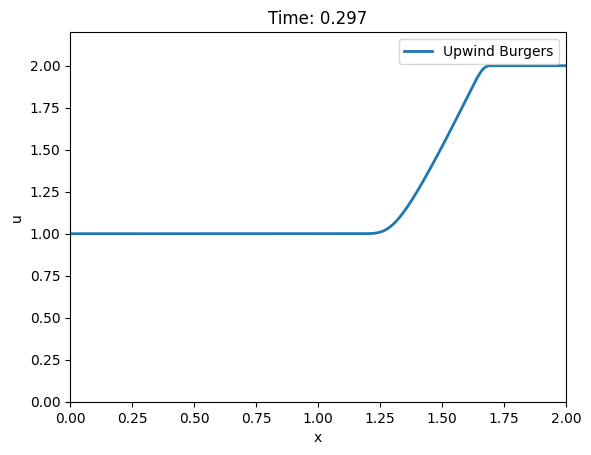

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# -----------------
# Parameters
# -----------------
nx = 201
L = 2.0
x = np.linspace(0, L, nx)
dx = x[1] - x[0]
CFL = 0.9
flow_time = 0.3
nu = 0.000  # viscosity; set 0 for inviscid

# Initial condition: shock-tube-like (low to high)
u0 = np.ones_like(x) * 1.0 # Start with a low value everywhere
u0[x >= 0.5*L] = 2.0      # Set the right half to a high value
u = u0.copy()

umax = np.max(np.abs(u0))
dt_adv = CFL * dx / umax
dt_diff = CFL * dx**2 / nu if nu > 0 else np.inf
dt = min(dt_adv, dt_diff)
nt = int(flow_time / dt) + 1

print(f"dx={dx:.4f}, dt={dt:.4e}, nt={nt}, nu={nu}")

# -----------------
# Control number of frames
# -----------------
desired_frames = 200
snapshot_interval = max(nt // desired_frames, 1)
frame_times = np.arange(0, nt, snapshot_interval)
actual_frames = len(frame_times)
print(f"Desired frames={desired_frames}, snapshot interval={snapshot_interval}, actual frames={actual_frames}")

# -----------------
# Set up the figure
# -----------------
fig, ax = plt.subplots()
line, = ax.plot(x, u0, lw=2, label='Upwind Burgers')
ax.set_xlim(0, L)
ax.set_ylim(0, 2.2) # Keep the y-limit consistent with the new range
ax.set_xlabel("x")
ax.set_ylabel("u")
title = ax.set_title("Time: 0.000")
ax.legend()

# -----------------
# Time-stepping function with upwinding
# -----------------
def update(frame_idx):
    global u
    for _ in range(snapshot_interval):
        un = u.copy()

        # A more robust and commonly seen way for the advection term's derivative:
        # Instead of dudx, let's consider the flux F(u) = 0.5 * u^2.
        # The equation is du/dt + dF/dx = nu * d2u/dx2
        # So we need dF/dx.
        # For upwind, if u > 0, we use backward difference for dF/dx.
        # This is for the derivative of the flux. Your original code directly
        # applied upwinding to du/dx, which is also a valid approach for
        # the non-linear advection term (often called the 'conservative' form
        # or 'non-conservative' depending on implementation).
        # Let's stick to your original form but with the corrected indexing for dudx.

        dudx_upwind = np.zeros_like(un)

        # Cases where u is positive (uses backward difference)
        # These are points where u[i] is positive, influencing the flux from left to right.
        # The derivative at `i` depends on `u[i]` and `u[i-1]`.
        positive_u_indices = np.where(un[1:] >= 0)[0] + 1 # Indices in the original array 'un' from 1 to nx-1
        dudx_upwind[positive_u_indices] = (un[positive_u_indices] - un[positive_u_indices - 1]) / dx

        # Cases where u is negative (uses forward difference)
        # These are points where u[i] is negative, influencing the flux from right to left.
        # The derivative at `i` depends on `u[i+1]` and `u[i]`.
        negative_u_indices = np.where(un[:-1] < 0)[0] # Indices in the original array 'un' from 0 to nx-2
        dudx_upwind[negative_u_indices] = (un[negative_u_indices + 1] - un[negative_u_indices]) / dx

        # Compute diffusion term (central second order)
        d2udx2 = np.zeros_like(u)
        d2udx2[1:-1] = (un[2:] - 2*un[1:-1] + un[:-2]) / dx**2

        # Update u
        # Note: dudx_upwind at index 0 and nx-1 might not be correctly computed by the above
        # vectorized parts if the boundary conditions are not considered for dudx calculation.
        # However, since u[0] and u[-1] are fixed by boundary conditions,
        # we only need dudx_upwind for the interior points [1:-1] which are covered.
        u[1:-1] = un[1:-1] - un[1:-1] * dt * dudx_upwind[1:-1] + nu * dt * d2udx2[1:-1]

        # Boundary conditions: fixed
        u[0] = u0[0]
        u[-1] = u0[-1]

    line.set_ydata(u)
    time = frame_times[frame_idx] * dt
    title.set_text(f"Time: {time:.3f}")
    return line, title


ani = FuncAnimation(fig, update, frames=actual_frames, interval=30, blit=True)

# -----------------
# Save animation to HTML5
# -----------------
html_anim = ani.to_html5_video()
HTML(html_anim)